## Predicting Damage with Decision Trees

In [1]:
pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 5.8 MB/s 


In [2]:
import sqlite3
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from category_encoders import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def wrangle(db_path):
    # # Connect to database
    # conn = sqlite3.connect(db_path)

    # # Construct query
    # query = """
    #     SELECT distinct(i.building_id) AS b_id,
    #        s.*,
    #        d.damage_grade
    #     FROM id_map AS i
    #     JOIN building_structure AS s ON i.building_id = s.building_id
    #     JOIN building_damage AS d ON i.building_id = d.building_id
    #     WHERE district_id = 4
    # """

    df = pd.read_excel(db_path)


    # Read query results into DataFrame
    # df = pd.read_sql(query, conn, index_col="b_id")
    
    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]
    
    # Create Binary Target
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
    
    # Drop old target
    drop_cols.append("damage_grade")
    
    # Drop multicollinearity columns
    drop_cols.append("count_floors_pre_eq")
    
    # Drop high-cardinality column
    drop_cols.append("building_id")
    
    # Drop columns
    df.drop(columns=drop_cols, inplace=True)

    
    return df

In [5]:
df = wrangle("/content/data_1.xlsx")
df.head()

,Unnamed: 0,b_id,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
0,1,164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
1,2,164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
2,3,164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
3,4,164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
4,5,164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0


In [7]:
df.shape

(70836, 14)

In [6]:
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [10]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.64


In [11]:
# Build Model
model = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=6, random_state=42)
)
# Fit model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
Others                              9
Building with Central Courtyard    10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                   

In [12]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_val = model.score(X_val, y_val)

print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.74
Validation Accuracy: 0.73


In [13]:
tree_depth = model.named_steps["decisiontreeclassifier"].get_depth()
print("Tree Depth:", tree_depth)

Tree Depth: 6


In [14]:
depth_hyperparams = range(1, 50, 2)

In [15]:
# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=d, random_state=42)
)
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.7071072484228174, 0.7102395553006573, 0.7311289539859708]
Validation Accuracy Scores: [0.7088406564319746, 0.7121934003882124, 0.724104464443268]


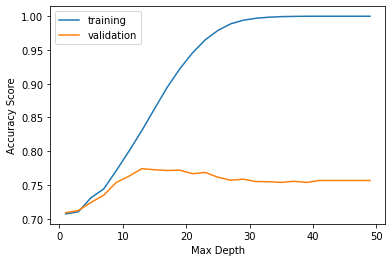

In [16]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams, training_acc, label="training")
plt.plot(depth_hyperparams, validation_acc, label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

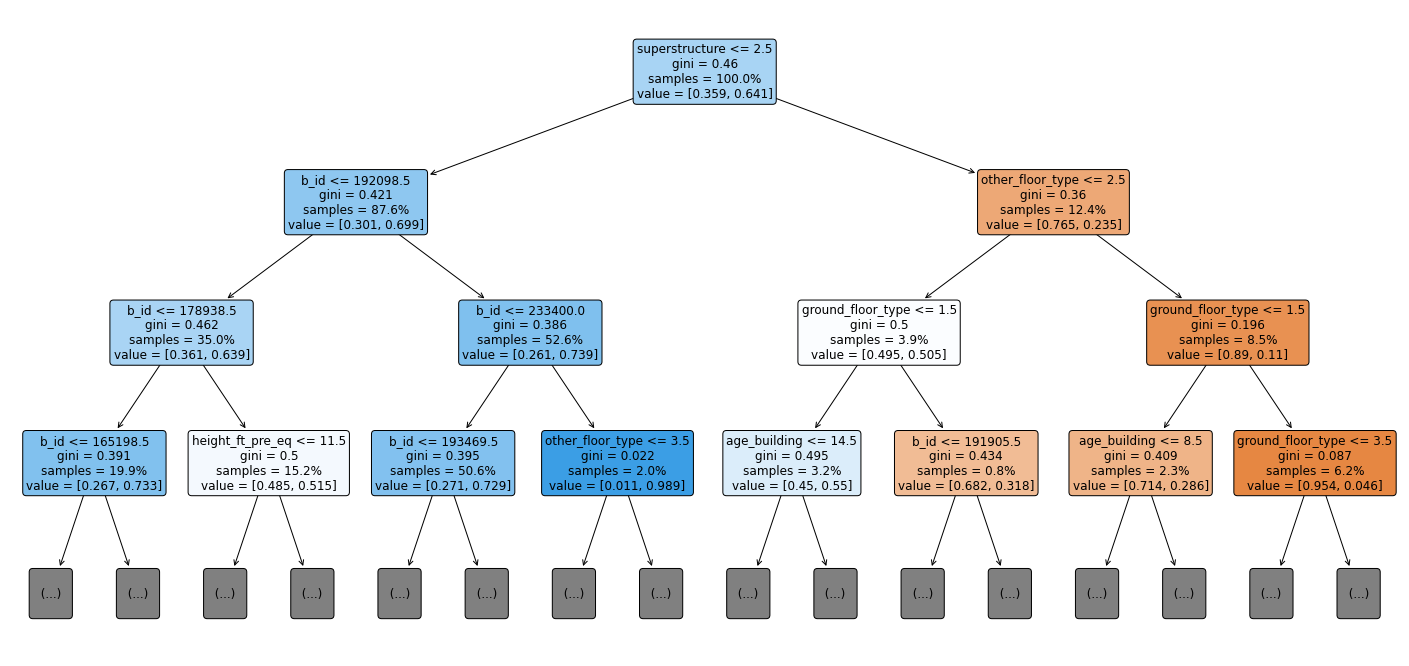

In [17]:
# Create larger figure
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    decision_tree=model.named_steps["decisiontreeclassifier"],
    feature_names=X_train.columns,
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

In [18]:
features = X_train.columns
importances = model.named_steps["decisiontreeclassifier"].feature_importances_

print("Features:", features[:3])
print("Importances:", importances[:3])

Features: Index(['Unnamed: 0', 'b_id', 'age_building'], dtype='object')
Importances: [0.0033172  0.38926721 0.01639474]


In [19]:
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.head()

plan_configuration        0.000000
land_surface_condition    0.000659
roof_type                 0.001030
position                  0.001212
foundation_type           0.002042
dtype: float64

In [20]:
feat_imp.sum()

1.0

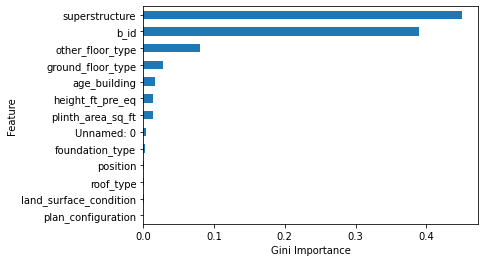

In [21]:
# Create horizontal bar chart
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature");